In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from pydeseq2.preprocessing import deseq2_norm

from combat.pycombat import pycombat

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import matthews_corrcoef, confusion_matrix

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

from datetime import datetime, timedelta

from collections import Counter

from joblib import parallel_backend

## Caricamento datasets, visualizzazione

C'è chiara distinzione tra i primi 82 samples e gli ultimi 48. Probabilmente dovuto ai batches in cui sono stati divisi gli RNA durante il sequenziamento. Normalizzare inter-sample usando mrn non aiuta.

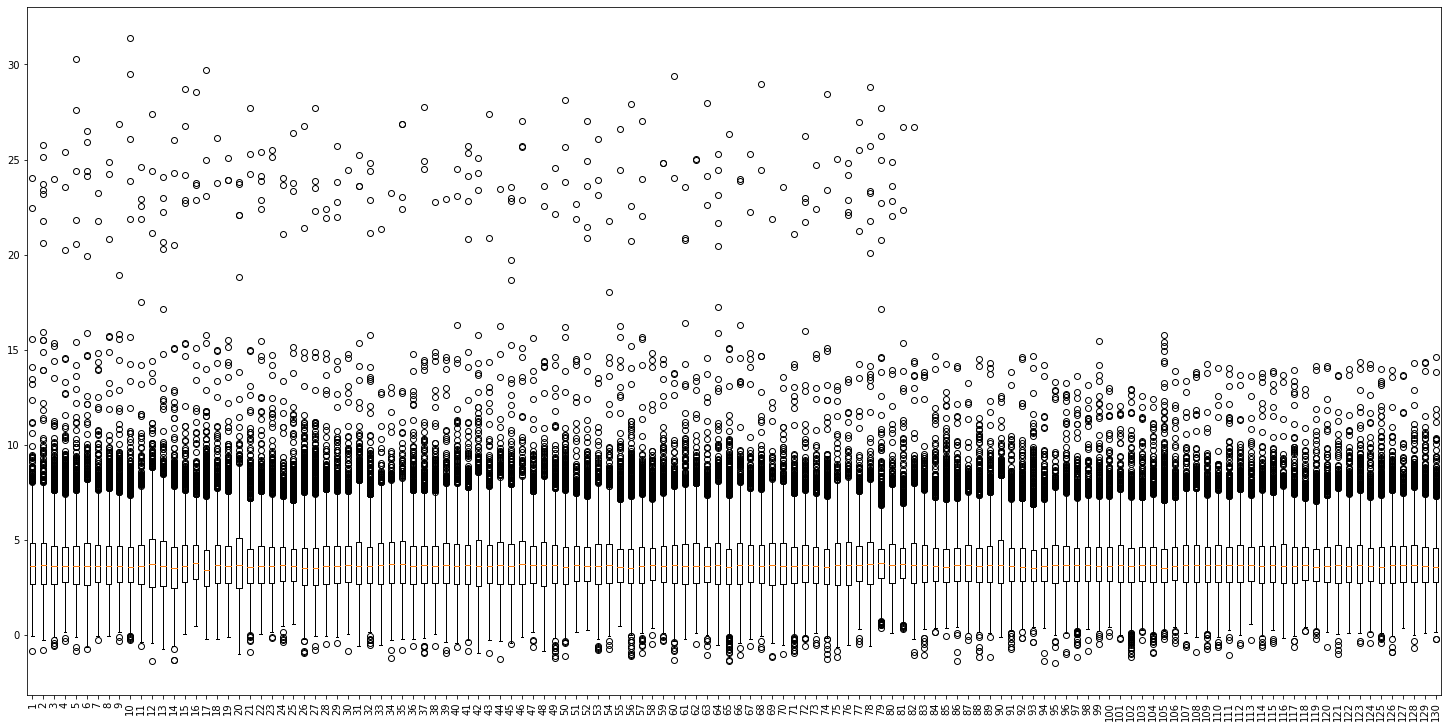

In [3]:
RNA_raw = pd.read_csv("RNAseq.txt", sep="\t", index_col=0)

meta_raw = pd.read_csv("metadata.csv")
clinical_raw = pd.read_csv("ClinicalData.csv",index_col="Case ID")
RNA_raw = pd.read_csv("RNAseq.txt", sep="\t", index_col=0)

IDs_meta = meta_raw["Subject ID"].unique() #144
IDs_clinical = clinical_raw.index #211
IDs_RNA = RNA_raw.columns #130

IDs_inter = [y for y  in [x for x in IDs_RNA if x in IDs_meta] if y in IDs_clinical] #117

RNA_noNA = RNA_raw.dropna()

#fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout=True)
fig, ax2 = plt.subplots(1,1,constrained_layout=True)

#ax1.boxplot(np.log2(RNA_noNA))

RNA_deseq2 = deseq2_norm(RNA_noNA.to_numpy().T)[0].T
ax2.boxplot(np.log2(RNA_deseq2))
ax2.set_xticklabels(ax2.get_xticks(), rotation=90)

#fig.set_size_inches(30,10)
fig.set_size_inches(20,10)

plt.show()


PCA conferma questa distinzione:

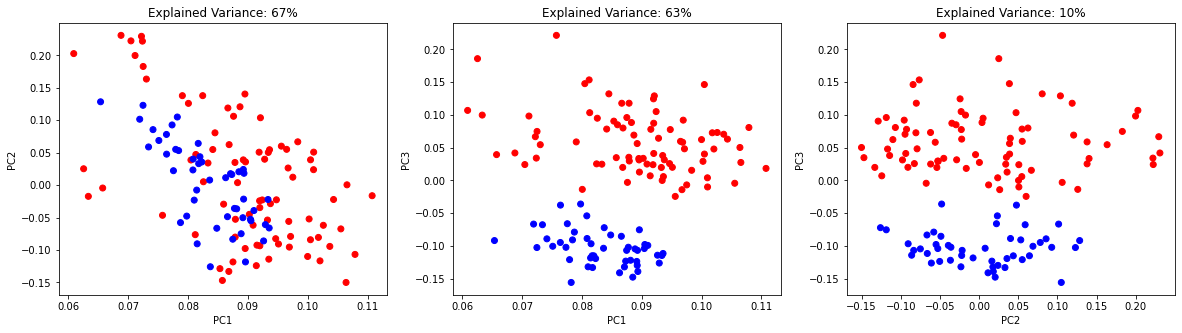

In [3]:
pca = PCA()
pca.fit_transform(np.log2(RNA_deseq2))

fig, (ax1,ax2,ax3) = plt.subplots(1,3)

colors = ["red"]*82 + ["blue"]*48

ax1.scatter(pca.components_[0], pca.components_[1], c=colors)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100:.0f}%")

ax2.scatter(pca.components_[0], pca.components_[2], c=colors)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC3")
ax2.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[2])*100:.0f}%")

ax3.scatter(pca.components_[1], pca.components_[2], c=colors)
ax3.set_xlabel("PC2")
ax3.set_ylabel("PC3")
ax3.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])*100:.0f}%")

fig.set_size_inches(20,5)

plt.show()

Lista degli RNA che scombussolano l'intero dataset:

In [4]:
RNA_big_list = list()

for col in RNA_noNA.columns:
    column = RNA_noNA[col]
    RNA_big_list.extend(column[column > np.e**12].index.to_list())

RNA_big_series = pd.Series(Counter(RNA_big_list)).sort_values(ascending=False)
with open("RNA_bigs.txt", "w") as file:
    for i in RNA_big_series.index:
        file.write(i+"\n")

print(RNA_big_series[RNA_big_series > 1])
print(f"number of RNAs with quantity above e^12: {len(RNA_big_series)}")

TOR1AIP1     62
ZFYVE26      40
CHD7         24
SEC22A       11
SYPL1        10
SAV1          9
RAB11FIP4     4
TSNARE1       3
VGLL4         2
CDK5RAP1      2
FAF1          2
APP           2
SETD3         2
CDKL5         2
FAM172A       2
TRAF3         2
dtype: int64
number of RNAs with quantity above e^12: 67


Utilizzo ComBat per fare batch normalization. Funziona, ma solo se faccio la normalizzazione sul log del dataset.

Using batch 1 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\Users\adri9\AppData\Local\Programs\Python\Python310\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


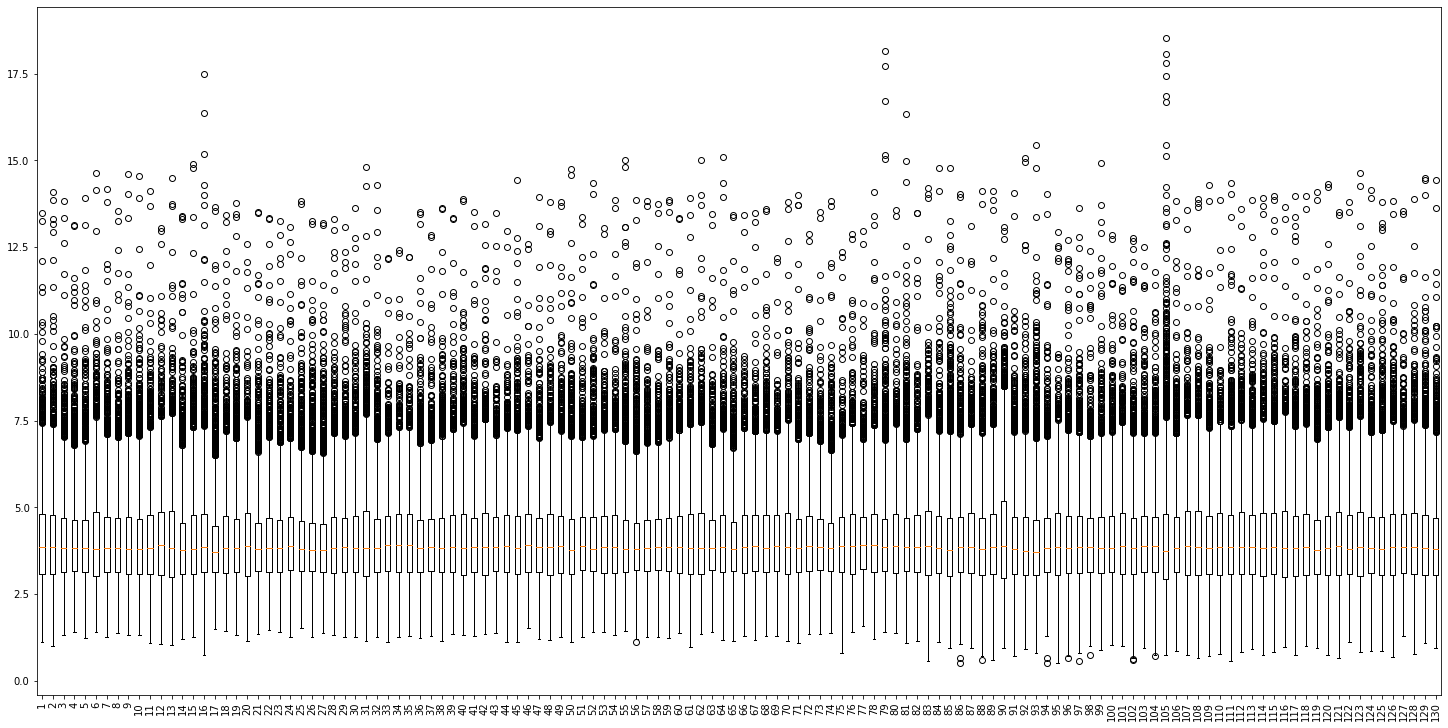

In [5]:

#fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout=True)
fig, ax2 = plt.subplots(1,1,constrained_layout=True)

RNA_log_combat = pycombat(np.log2(RNA_noNA+1), [0]*82 + [1]*48, ref_batch=1)

RNA_log_combat_deseq2 = deseq2_norm(RNA_log_combat.to_numpy().T)[0].T
RNA_log_combat_deseq2 = pd.DataFrame(RNA_log_combat_deseq2, index=RNA_log_combat.index, columns=RNA_log_combat.columns)


#ax1.boxplot(RNA_log_combat)
ax2.boxplot(RNA_log_combat_deseq2)
ax2.set_xticklabels(ax2.get_xticks(), rotation=90)
#fig.set_size_inches(30,10)
fig.set_size_inches(20,10)
plt.show()

Adesso la PCA non mostra distinzione tra i batch:

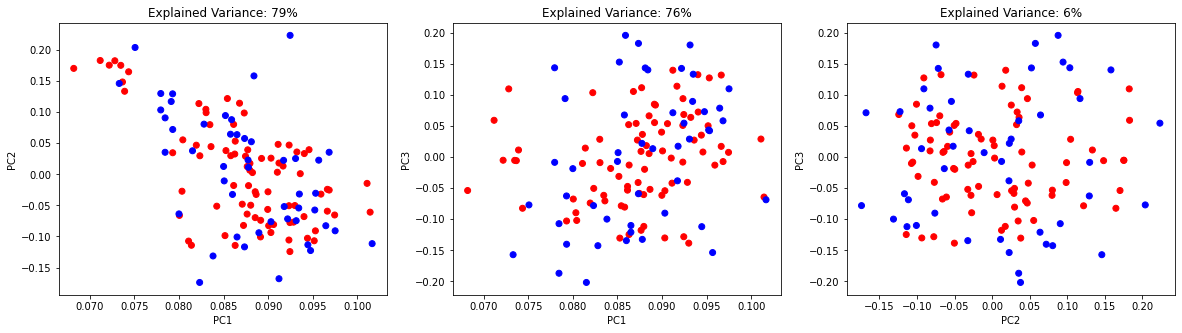

In [6]:
colors = ["red"]*82 + ["blue"]*48

pca = PCA()
pca.fit_transform(RNA_log_combat_deseq2)
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.scatter(pca.components_[0], pca.components_[1], c=colors)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100:.0f}%")

ax2.scatter(pca.components_[0], pca.components_[2], c=colors)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC3")
ax2.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[2])*100:.0f}%")

ax3.scatter(pca.components_[1], pca.components_[2], c=colors)
ax3.set_xlabel("PC2")
ax3.set_ylabel("PC3")
ax3.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])*100:.0f}%")

fig.set_size_inches(20,5)

In [7]:
RNA_log_combat_deseq2.to_csv("RNAseq_norm.csv")

## Survival Analysis

Utilizzo di Kaplan-meier e di log-rank.
Per vedere come varia probabilità di sopravvivere per un certo lasso di tempo, in base a se il paziente fuma o meno. 
C'è differenza statisticamente significativa tra chi fuma e chi non ha mai fumato. 

         counts  observed   expected  statistic
group                                          
Current      33        16  10.873068   5.126932
Former      130        38  43.126932  -5.126932
chisq: 3.028580971947557
pvalue: 0.08180953669830804

           counts  observed   expected  statistic
group                                            
Current        33        16   9.443332   6.556668
Nonsmoker      48         9  15.556668  -6.556668
chisq: 7.394120247916804
pvalue: 0.006543742162661695

           counts  observed   expected  statistic
group                                            
Former        130        38  33.244662   4.755338
Nonsmoker      48         9  13.755338  -4.755338
chisq: 2.3356369531870733
pvalue: 0.12644326116880666



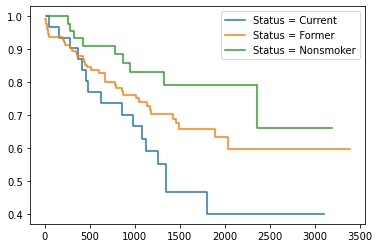

In [10]:

clinical_new = clinical_raw.copy()

def cambia_date(x):
    return datetime.strptime(x,"%m/%d/%Y")

def cambia_status(x):
    if x == "Dead":
        return True
    else:
        return False

survival_list = list()

for sample in clinical_raw.iterrows():

    date_last = cambia_date(sample[1]["Date of Last Known Alive"])
    date_CT = cambia_date(sample[1]["CT Date"])
    days_CT_surgery = timedelta(days=sample[1]["Days between CT and surgery"])

    if date_last - date_CT > days_CT_surgery: # caso in cui hanno fatto surgery dopo della CT
        delta = date_last - date_CT - days_CT_surgery
    else: # caso in cui hanno fatto surgery prima della CT
        delta = date_last - date_CT + days_CT_surgery

    survival_list.append(delta.days)

clinical_new["Days Survived"] = survival_list
clinical_new["Survival Status"] = clinical_raw["Survival Status"].apply(cambia_status)

clinical_smoker = clinical_new.groupby("Smoking status")

checker = []
for i,j in clinical_smoker: # per fare il plot
    time, survival_prob = kaplan_meier_estimator(event=j["Survival Status"].tolist(), time_exit=j["Days Survived"].tolist())
    plt.step(time, survival_prob, where="post",
             label=f"Status = {i}")

    for k,l in clinical_smoker: # per ottenere dati statistici
        if i != k and (i,k) not in checker:

            temp_df = pd.concat([j,l])
            my_list = [(x,y) for [x,y] in temp_df[["Survival Status", "Days Survived"]].to_numpy()]
            my_array = np.array(my_list, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
            chisq,pvalue,stats,covariance = compare_survival(y=my_array, group_indicator=temp_df["Smoking status"].to_list(), return_stats=True)


            print(stats)
            print(f"chisq: {chisq}")
            print(f"pvalue: {pvalue}")
            # print(covariance)
            print("")
            checker.append((i,k))
            checker.append((k,i))


plt.legend(loc="best")
plt.show()

          counts  observed   expected  statistic
group                                           
Stanford     118        28  30.773665  -2.773665
VA            93        35  32.226335   2.773665
chisq: 0.5017172017709404
pvalue: 0.4787465688656093



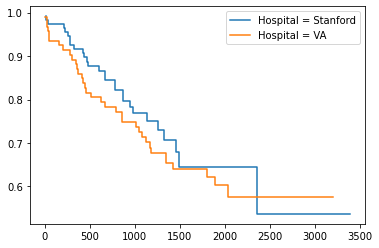

In [10]:

clinical_new = clinical_raw.copy()

def cambia_date(x):
    return datetime.strptime(x,"%m/%d/%Y")

def cambia_status(x):
    if x == "Dead":
        return True
    else:
        return False

survival_list = list()

for sample in clinical_raw.iterrows():

    date_last = cambia_date(sample[1]["Date of Last Known Alive"])
    date_CT = cambia_date(sample[1]["CT Date"])
    days_CT_surgery = timedelta(days=sample[1]["Days between CT and surgery"])

    if date_last - date_CT > days_CT_surgery: # caso in cui hanno fatto surgery dopo della CT
        delta = date_last - date_CT - days_CT_surgery
    else: # caso in cui hanno fatto surgery prima della CT
        delta = date_last - date_CT + days_CT_surgery

    survival_list.append(delta.days)

clinical_new["Days Survived"] = survival_list
clinical_new["Survival Status"] = clinical_raw["Survival Status"].apply(cambia_status)

clinical_smoker = clinical_new.groupby("Patient affiliation")

checker = []
for i,j in clinical_smoker: # per fare il plot
    time, survival_prob = kaplan_meier_estimator(event=j["Survival Status"].tolist(), time_exit=j["Days Survived"].tolist())
    plt.step(time, survival_prob, where="post",
             label=f"Hospital = {i}")

    for k,l in clinical_smoker: # per ottenere dati statistici
        if i != k and (i,k) not in checker:

            temp_df = pd.concat([j,l])
            my_list = [(x,y) for [x,y] in temp_df[["Survival Status", "Days Survived"]].to_numpy()]
            my_array = np.array(my_list, dtype=[('Hospital', '?'), ('Survival_in_days', '<f8')])
            chisq,pvalue,stats,covariance = compare_survival(y=my_array, group_indicator=temp_df["Patient affiliation"].to_list(), return_stats=True)


            print(stats)
            print(f"chisq: {chisq}")
            print(f"pvalue: {pvalue}")
            # print(covariance)
            print("")
            checker.append((i,k))
            checker.append((k,i))


plt.legend(loc="best")
plt.show()

In [16]:
clinical_new.to_csv("clinical_new.csv")

RNA_log_combat_deseq2.to_csv("RNA_new.csv")

## Differential Expression Analysis

Rifacendo la PCA adesso è visibile una distinzione tra RNA provenienti da adenocarcinoma e RNA che non lo sono.

Counter({'blue': 88, 'red': 26, 'black': 3})


ValueError: 'c' argument has 117 elements, which is inconsistent with 'x' and 'y' with size 130.

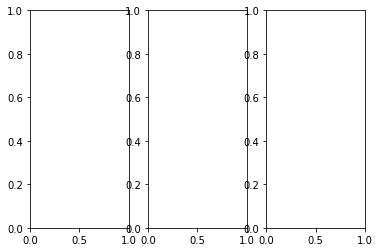

In [17]:
#colors = ["red"]*69 + ["blue"]*48

def coloratore(stato):
    if stato == "Adenocarcinoma":
        return "blue"
    elif stato == 'Squamous cell carcinoma':
        return "red"
    else:
        return "black"

colors = clinical_raw.loc[IDs_inter,"Histology "].apply(coloratore)
print(Counter(colors))

pca = PCA()
pca.fit_transform(RNA_log_combat_deseq2)
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.scatter(pca.components_[0], pca.components_[1], c=colors)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100:.0f}%")

ax2.scatter(pca.components_[0], pca.components_[2], c=colors)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC3")
ax2.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[2])*100:.0f}%")

ax3.scatter(pca.components_[1], pca.components_[2], c=colors)
ax3.set_xlabel("PC2")
ax3.set_ylabel("PC3")
ax3.set_title(f"Explained Variance: {(pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])*100:.0f}%")

fig.set_size_inches(20,5)

### Linear Discriminant Analysis

Per prevedere se un tumore è adenocarcinoma o meno. 

Per prima cosa filtro gli RNA con varianza molto bassa tra tutti i sample. 

In [ ]:
RNA_low_variance_mask = RNA_log_combat_deseq2.T.var() > RNA_log_combat_deseq2.T.var().quantile(0.05)

RNA_filtered = RNA_log_combat_deseq2[RNA_low_variance_mask].loc[:,IDs_inter]

print(RNA_filtered.shape)


(5055, 117)


LDA riesce a distinguere abbastanza bene gli adenocarcinoma. 

Il Matthews correlation coefficient alla file è attorno a 0.7 +- 0.15.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2) 

x = RNA_filtered.columns
y = clinical_new.loc[IDs_inter,"Histology "] == "Adenocarcinoma"
mccs = []

sss.get_n_splits(x,y)

features = pd.Series(0, index=RNA_filtered.index)

for i in sss.split(x,y):

    x_train = x[i[0]]
    y_train = y[i[0]]
    x_test = x[i[1]]
    y_test = y[i[1]]

    with parallel_backend("threading",n_jobs=-1):
        LDA = LinearDiscriminantAnalysis()
        LDA.fit(RNA_filtered[x_train].T,y_train)
    

    predictions = LDA.predict(RNA_filtered[x_test].T)

    # conf_matrix = confusion_matrix(y_test,predictions)
    # print(conf_matrix)


    mcc = matthews_corrcoef(y_test, predictions)
    mccs.append(mcc)

    features = features.add(LDA.coef_[0])


pd.set_option("display.max_rows", None)

# print(features)

print(pd.Series(mccs).describe())

count    100.000000
mean       0.713734
std        0.140461
min        0.258199
25%        0.654654
50%        0.774597
75%        0.777778
max        1.000000
dtype: float64


Counter({False: 4889, True: 166})


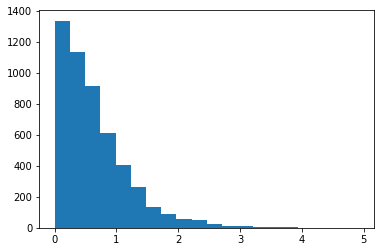

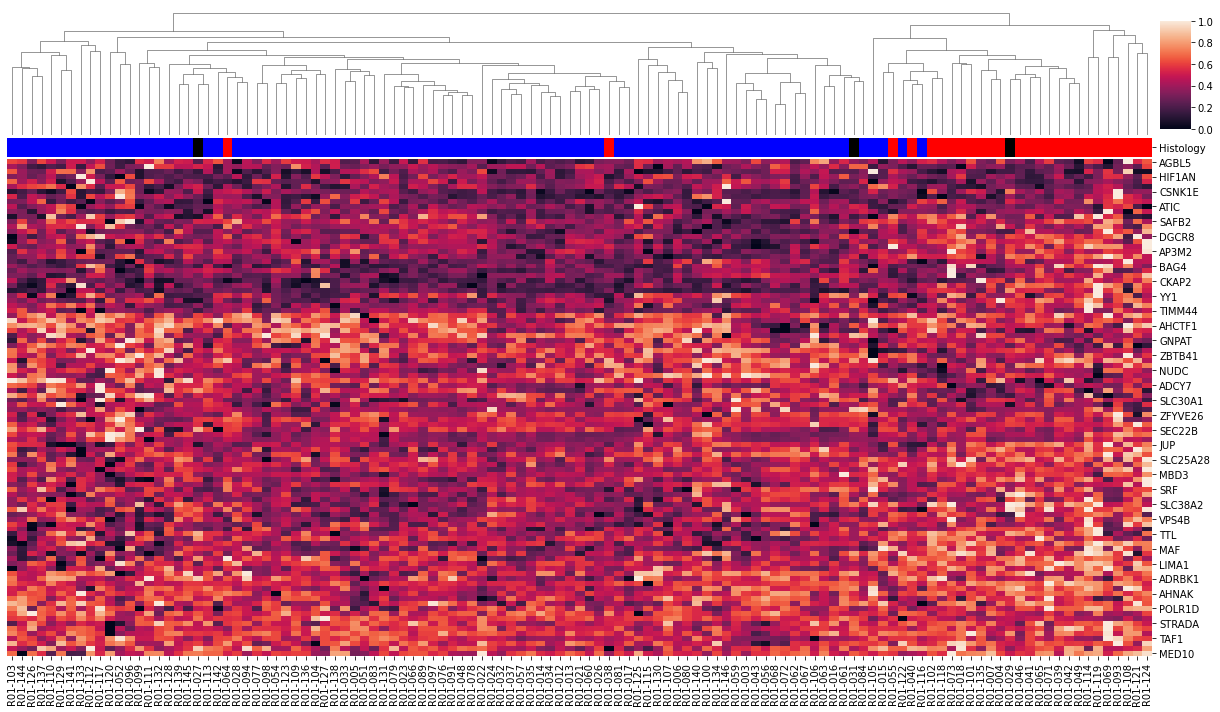

In [ ]:
import seaborn

RNA_abs = features.abs().sort_values(ascending=False)

pd.Series(RNA_abs.index).to_csv("RNA_top.txt", sep="\t", index=False)

print(Counter(RNA_abs > 2))

plt.hist(RNA_abs, bins=20)

heat = seaborn.clustermap(RNA_filtered.loc[RNA_abs.index[:100],:],
                          standard_scale=0,
                          col_colors=colors,
                          cbar_pos=(0.96, 0.815, 0.02, 0.15),
                          method="complete",
                          figsize=(21,10),
                          xticklabels=1)

heat.ax_row_dendrogram.set_visible(False)

plt.show()